# Problem: Do qualifications determine race results in Formula 1?

Formula 1 is a pinnacle of motosport, but also a sport that is driven by data. Throught its 73-year history, a lot of data has been gathered during the racing weekends (yet not all of it published for obvious strategic reasons). Every racing weekend, a question arises of how important the starting grid postition is for the race finish. Does pole position translate to an automatic victory? If that was the case, what are the drivers even racing for? The purpose of this project is to explore the link between qualifying results and the finishing position in the race through the means of ML and NN.

## Datasets used

- df_drivers: info about drivers, could be deemed irrelevant (possible analysis: link between nationality and the racing country)
- df_qualifying: info about starting grid positions, lap times in each part of the quali (Q1 all drivers, Q2 top15, Q3 top10)
- df_races: info about every racing weekend in history, includes dates and times to be ignored
- df_results: results for every driver who took part in the grand prix


In [2]:
import numpy as np # linear algebra
import pandas as pd 

  
    
df_drivers = pd.read_csv("/Users/lenovo/Downloads/Data Race F1/drivers.csv")
df_races = pd.read_csv("/Users/lenovo/Downloads/Data Race F1/races.csv")
df_results = pd.read_csv("/Users/lenovo/Downloads/Data Race F1/results.csv")    
df_qualifying = pd.read_csv("/Users/lenovo/Downloads/Data Race F1/qualifying.csv")
        


## Datasets unused

- constructor_results.csv
- constructor_standings.csv
- constructors.csv
- pit_stops.csv
- df_seasons.csv
- df_sprint_results.csv
- df_standings
- df_circuits
- df_lap_times
- df_status

# Data selection

From the chosen datasets, a subset of columns relevant for the analysis is chosen. Redundant columns are removed and variables not of interest. The year of the race has been added to the dataframe containing results, as well as the date of the Grand Prix.

In [3]:
df_results.head(10)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
5,6,18,6,3,8,13,6,6,6,3.0,57,\N,\N,50,14,1:29.639,212.974,11
6,7,18,7,5,14,17,7,7,7,2.0,55,\N,\N,22,12,1:29.534,213.224,5
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,\N,20,4,1:27.903,217.180,5
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,\N,15,9,1:28.753,215.100,4
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,\N,23,13,1:29.558,213.166,3


In [4]:
#ADD: Date to df_results

df_new = df_races.loc[:, ['raceId', 'date']].drop_duplicates(subset=['raceId'])

df_new = df_new.sort_values(by='date', key=lambda x: x.str.split('-'))

df_new['raceIdOrdered'] = range(1,len(df_new)+1)


#ADD: Correct order of races to df_results

df_results = pd.merge(df_results, df_new.loc[:, ['raceId', 'raceIdOrdered']], how='left', on=['raceId'], )


#SORT: Dataframe based on order of races

df_results = df_results.sort_values(by='raceIdOrdered')


#ADD: years to dataframe results

df_results = df_results.set_index('raceId').join(df_races.loc[:,['year', 'raceId']].set_index('raceId'), on='raceId').reset_index()

df_results = df_results.loc[:,['raceId', 'driverId', 'grid', 'positionOrder', 'year', 'raceIdOrdered']]

df_results = df_results.rename(columns={'positionOrder' : 'racePosition', 'grid': 'startingPosition'})

df_results.head(10)

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered
0,833,660,21,11,1950,1
1,833,790,12,21,1950,1
2,833,579,3,12,1950,1
3,833,661,10,20,1950,1
4,833,789,7,19,1950,1
5,833,589,11,18,1950,1
6,833,640,8,17,1950,1
7,833,785,17,16,1950,1
8,833,747,18,15,1950,1
9,833,778,20,10,1950,1


Adding the year in which the driver has started racing, for the purpose of creating additional variable of exparience (later in the code)

In [5]:
#ADD: year in which driver started racing

min_year = df_results.groupby('driverId').min()['year']

min_year = (min_year.reset_index()).rename({'year':'yearStarted'}, axis=1)

df_results = df_results.merge(min_year, on='driverId',how='left')

df_results

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted
0,833,660,21,11,1950,1,1950
1,833,790,12,21,1950,1,1950
2,833,579,3,12,1950,1,1950
3,833,661,10,20,1950,1,1950
4,833,789,7,19,1950,1,1950
...,...,...,...,...,...,...,...
26075,1110,815,2,2,2023,1091,2011
26076,1110,830,6,1,2023,1091,2015
26077,1110,832,4,19,2023,1091,2015
26078,1110,840,10,9,2023,1091,2017


Adding the number of races in which the driver has participated, for the purpose of creating additional variable of exparience (measured in number of races)

In [6]:
#ADD: in how many races did the driver participate (changes every race)

def count_race_exp(df):
    
    sol = []
    
    for index, row in df.iterrows():
        
        df_new = df.loc[:index]
        
        df_new = df_new[df_new['driverId'] == row['driverId']]
        
        sol.append(len(df_new))
        
    return sol


df_results['driverExpRaces'] = count_race_exp(df_results)

df_results[df_results['driverId'] == 9] 

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces
19116,65,9,9,22,2006,763,2006,1
19141,66,9,8,12,2006,764,2006,2
19172,67,9,6,3,2006,765,2006,3
19184,68,9,9,13,2006,766,2006,4
19209,69,9,12,9,2006,767,2006,5
...,...,...,...,...,...,...,...,...
24566,1028,9,19,19,2019,1016,2006,95
24583,1029,9,19,16,2019,1017,2006,96
24604,1030,9,19,19,2019,1018,2006,97
25205,1064,9,16,15,2021,1048,2006,98


Formula 1 has changed a lot throught the years. The number of races has grown and the regulations affecting how the cars are manufactured have changed. This may lead to possible difficulties when it comes to model training and the quality of its predictions.

<Axes: title={'center': 'Number of races per year'}, xlabel='Year', ylabel='Total number of races'>

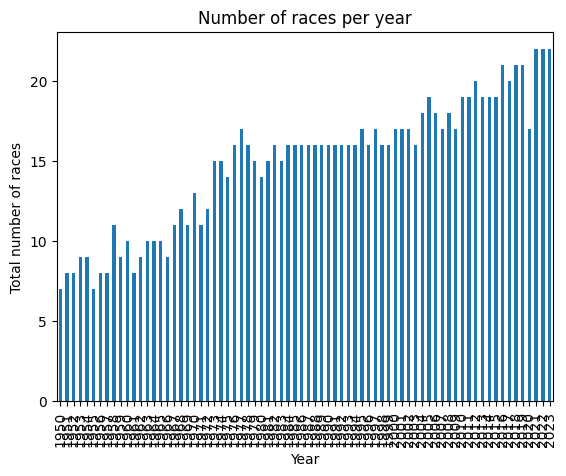

In [7]:
#EVAL: How the number of races changed throught the years?

races_per_years = df_races['year'].value_counts()

race_ids_per_years = df_races.groupby('year')['raceId'].agg(list)

races_per_years = pd.concat([races_per_years, race_ids_per_years], axis=1).reset_index()

races_per_years.columns = ['Year', 'Total', 'RaceIds']

races_per_years = races_per_years.sort_values(by='Year')

races_per_years.plot(x='Year', 
           y='Total',
           kind='bar',
          xlabel = 'Year',
          ylabel = 'Total number of races',
          legend = False,
          title = 'Number of races per year')

## Missing data

Are there any years for which there is data missing for some races? Yes, for the year 2023.

In [8]:
#EVAL: Not every race for a year in data

data_for_races = df_results.loc[:,['raceId','year']].groupby('year').nunique()

data_expected = races_per_years.set_index('Year')['Total']

data_for_races = data_for_races.join(data_expected)

data_for_races['diff'] = data_for_races['Total'] - data_for_races['raceId']

data_for_races[data_for_races['diff'] != 0]

,raceId,Total,diff
year,,,
2023,12,22,10


In the dataset, the first year for which there is information about qualifying is 1994. The closest to the current format of qualifying was first introduced in 1996. It differs from the current system in limiting drivers to 12 laps only, while currently there is no limits on the number of laps to be completed. Huge changes and a lot af variation was introduced to the qualifying format between 2003 and 2005. Starting with the year 2006, a three-part system of qualifying was introduced.These days, drivers are limited by time in which they have to complete the fastest lap they can. After each round of qualifying, 5 drivers with the worst lap times are eliminated, so that only 10 advance to the final round (Q3). **For these reasons, we limit the data to years 2006 - 2022.** (For which we have the full quali information)

*SOURCE: https://www.formula1.com/en/latest/features/2016/3/deciding-the-grid-a-history-of-f1-qualifying-formats.html*

Firstly, models will be trained on the dataset for the years 2006 - 2022. If these models perform poorly, the training dataset will be changed and will focus only on one chosen era of F1 (the most recent hybrid era of 2014-2021).

In [9]:
#ADD: Years to df_qualifying

years = df_races.loc[:,['year', 'raceId']].set_index('raceId')

df_qualifying = df_qualifying.set_index('raceId').join(years, on='raceId').reset_index()

print("First quali info: ", df_qualifying['year'].min())

First quali info:  1994


In [10]:
#REMOVE: 2003 - 2005 from qualifying

df_qualifying = df_qualifying[(df_qualifying['year'] <= 2002) | (df_qualifying['year'] >= 2006)]

#REMOVE: any years but 2006 - 2022 from results
df_results = df_results[(df_results['year'] >= 2006) & (df_results['year'] <= 2022)]

#REMOVE: Driver in table, but didn't start a race

df_results = df_results[df_results['startingPosition'] != 0]

Evaluating, whether there is qualification data for all the races

In [11]:
#EVAL: Quali info missing for a race

x = df_results['raceId'].unique()

y = df_qualifying['raceId'].unique()

np.where(np.isin(x, y) == False)

(array([], dtype=int64),)

In [12]:
#REMOVE: Races for which there is no quali info

df_results = df_results[df_results['raceId'].isin(y)]

x = df_results['raceId'].unique()

print(np.where(np.isin(x, y) == False))

#MERGE: joining df_qualifying, df_results into one DF

df = pd.merge(df_results, df_qualifying,  how='left', left_on=['raceId','driverId'], right_on = ['raceId','driverId'])

df = df.drop(['year_y', 'constructorId', 'qualifyId', 'number'], axis = 1)

df = df.rename(columns={'year_x' : 'year', 'position' : 'qualiResultPosition'})

df.head(10)

(array([], dtype=int64),)


,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,q1,q2,q3
0,53,22,6,15,2006,751,1993,219,6.0,1:33.922,1:32.322,1:32.579
1,53,15,14,16,2006,751,1997,150,14.0,1:33.987,1:33.066,\N
2,53,33,19,17,2006,751,2005,20,19.0,1:35.900,\N,\N
3,53,11,20,18,2006,751,2002,53,20.0,1:37.411,\N,\N
4,53,27,18,22,2006,751,2005,20,18.0,1:35.724,\N,\N
5,53,35,11,20,2006,751,1996,154,11.0,1:33.882,1:32.456,\N
6,53,21,9,21,2006,751,1996,162,9.0,1:32.934,1:31.831,1:33.496
7,53,23,17,14,2006,751,1997,146,17.0,1:34.702,\N,\N
8,53,34,21,19,2006,751,2006,1,21.0,1:40.270,\N,\N
9,53,26,16,13,2006,751,2006,1,16.0,1:33.995,1:34.606,\N


Adding drivers' nationality for later purpose.

In [13]:
#ADD: drivers' nationality

df = df.merge(df_drivers.loc[:,['driverId','nationality']],how='left', on='driverId')

#EVAL: null/nan values in nationality column

print(df[df['nationality'].isna()])

df.head(10)

Empty DataFrame
Columns: [raceId, driverId, startingPosition, racePosition, year, raceIdOrdered, yearStarted, driverExpRaces, qualiResultPosition, q1, q2, q3, nationality]
Index: []


,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,q1,q2,q3,nationality
0,53,22,6,15,2006,751,1993,219,6.0,1:33.922,1:32.322,1:32.579,Brazilian
1,53,15,14,16,2006,751,1997,150,14.0,1:33.987,1:33.066,\N,Italian
2,53,33,19,17,2006,751,2005,20,19.0,1:35.900,\N,\N,Portuguese
3,53,11,20,18,2006,751,2002,53,20.0,1:37.411,\N,\N,Japanese
4,53,27,18,22,2006,751,2005,20,18.0,1:35.724,\N,\N,Dutch
5,53,35,11,20,2006,751,1996,154,11.0,1:33.882,1:32.456,\N,Canadian
6,53,21,9,21,2006,751,1996,162,9.0,1:32.934,1:31.831,1:33.496,Italian
7,53,23,17,14,2006,751,1997,146,17.0,1:34.702,\N,\N,German
8,53,34,21,19,2006,751,2006,1,21.0,1:40.270,\N,\N,Japanese
9,53,26,16,13,2006,751,2006,1,16.0,1:33.995,1:34.606,\N,American


## Transforming the data

The goal is to replace the strings representing lap times to numbers (msec). It will make the operations needed to be completed to create additional variables easier.

In [14]:
#PROBLEM: How many drivers didn't set a time in q1 (= no pace established in quali)

df = df.replace('\\N', np.nan)

print("No lap time in q1 set: ", df['q1'].isnull().values.sum())

df = df[df['q1'].notnull()]

print("No lap time in q1 set (after removing): ", df['q1'].isnull().values.sum())

No lap time in q1 set:  79
No lap time in q1 set (after removing):  0


In [15]:
#PROBLEM: If a driver doesn't advance to the next round of quali, they don't set a lap time

df = df.fillna(0)

print("Null values in dataframe: ",df.isnull().values.any())

Null values in dataframe:  False


In [16]:
#PROBLEM: splitting lap time strings into format [min, sec, msec]


def get_time_lst(df, col):
    
    col_lst = df[col].str.split(pat=':|\.').fillna(0)
    
    return col_lst


df['q1_lst'] = get_time_lst(df, 'q1')
df['q2_lst'] = get_time_lst(df, 'q2')
df['q3_lst'] = get_time_lst(df, 'q3')


print("Null values in dataframe: ",df.isnull().values.any())

Null values in dataframe:  False


<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13352\1205070550.py:6: SyntaxWarning: invalid escape sequence '\.'
  col_lst = df[col].str.split(pat=':|\.').fillna(0)


In [17]:
def convert_to_msec(time_lst):
    
    if time_lst != 0:
    
        return int(time_lst[0])*60000 + int(time_lst[1])*1000 + int(time_lst[2])
    
    return 0

df['q1Msec'] = df.apply(lambda x: convert_to_msec(x['q1_lst']), axis=1)
df['q2Msec'] = df.apply(lambda x: convert_to_msec(x['q2_lst']), axis=1)
df['q3Msec'] = df.apply(lambda x: convert_to_msec(x['q3_lst']), axis=1)


print("Null values in dataframe (added q_Msec): ",df.isnull().values.any())


#df = df.loc[:,['raceId', 'qualifyId', 'driverId', 'position', 'year', 'q1Msec', 'q2Msec', 'q3Msec']]

#ADD: Max Pace in session

df['maxPace'] = df.loc[:, ['q1Msec', 'q2Msec', 'q3Msec']].max(axis=1)

print("Null values in dataframe (added maxPace): ",df.isnull().values.any())

#ADD: Mean Pace per session

df['meanPace'] = df.loc[:, ['q1Msec', 'q2Msec', 'q3Msec']].sum(axis=1) / (df.loc[:, ['q1Msec', 'q2Msec', 'q3Msec']] != 0).sum(axis=1)

print("Null values in dataframe (added meanPace): ",df.isnull().values.any())

df = df.drop(['q1_lst', 'q2_lst', 'q3_lst', 'q1', 'q2', 'q3'], axis = 1)

df.head(10)

Null values in dataframe (added q_Msec):  False
Null values in dataframe (added maxPace):  False
Null values in dataframe (added meanPace):  False


,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,nationality,q1Msec,q2Msec,q3Msec,maxPace,meanPace
0,53,22,6,15,2006,751,1993,219,6.0,Brazilian,93922,92322,92579,93922,92941.000000
1,53,15,14,16,2006,751,1997,150,14.0,Italian,93987,93066,0,93987,93526.500000
2,53,33,19,17,2006,751,2005,20,19.0,Portuguese,95900,0,0,95900,95900.000000
3,53,11,20,18,2006,751,2002,53,20.0,Japanese,97411,0,0,97411,97411.000000
4,53,27,18,22,2006,751,2005,20,18.0,Dutch,95724,0,0,95724,95724.000000
5,53,35,11,20,2006,751,1996,154,11.0,Canadian,93882,92456,0,93882,93169.000000
6,53,21,9,21,2006,751,1996,162,9.0,Italian,92934,91831,93496,93496,92753.666667
7,53,23,17,14,2006,751,1997,146,17.0,German,94702,0,0,94702,94702.000000
8,53,34,21,19,2006,751,2006,1,21.0,Japanese,100270,0,0,100270,100270.000000
9,53,26,16,13,2006,751,2006,1,16.0,American,93995,94606,0,94606,94300.500000


## An additional variable: experience

Long-time experience is important for F1. It allows you to adapt to the car you're driving, but also racing multiple times on the same circuits is an advantage. For this reason, it may be worth exploring if total years of experience or total number of race in which a driver participated play any role.

### In years 

In [18]:
#ADD: Drivers' expeirence that increases every year

df['driverExpYears'] = df['year'] - df['yearStarted']

df[df['driverId'] == 9]

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,nationality,q1Msec,q2Msec,q3Msec,maxPace,meanPace,driverExpYears
271,65,9,9,22,2006,763,2006,1,10.0,Polish,80891,80256,82049,82049,81065.333333,0
296,66,9,8,12,2006,764,2006,2,9.0,Polish,88212,87405,88167,88212,87928.000000,0
327,67,9,6,3,2006,765,2006,3,6.0,Polish,82437,81270,82258,82437,81988.333333,0
339,68,9,9,13,2006,766,2006,4,9.0,Polish,106049,105576,106632,106632,106085.666667,0
364,69,9,12,9,2006,767,2006,5,12.0,Polish,91204,91094,0,91204,91149.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,1028,9,19,19,2019,1016,2006,95,20.0,Polish,95889,0,0,95889,95889.000000,13
5709,1029,9,19,16,2019,1017,2006,96,19.0,Polish,70614,0,0,70614,70614.000000,13
5730,1030,9,19,19,2019,1018,2006,97,20.0,Polish,99236,0,0,99236,99236.000000,13
6318,1064,9,16,15,2021,1048,2006,98,18.0,Polish,71301,0,0,71301,71301.000000,15


### In number of races

Calculated before, presented below

In [19]:
df[df['driverId'] == 9]

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,nationality,q1Msec,q2Msec,q3Msec,maxPace,meanPace,driverExpYears
271,65,9,9,22,2006,763,2006,1,10.0,Polish,80891,80256,82049,82049,81065.333333,0
296,66,9,8,12,2006,764,2006,2,9.0,Polish,88212,87405,88167,88212,87928.000000,0
327,67,9,6,3,2006,765,2006,3,6.0,Polish,82437,81270,82258,82437,81988.333333,0
339,68,9,9,13,2006,766,2006,4,9.0,Polish,106049,105576,106632,106632,106085.666667,0
364,69,9,12,9,2006,767,2006,5,12.0,Polish,91204,91094,0,91204,91149.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,1028,9,19,19,2019,1016,2006,95,20.0,Polish,95889,0,0,95889,95889.000000,13
5709,1029,9,19,16,2019,1017,2006,96,19.0,Polish,70614,0,0,70614,70614.000000,13
5730,1030,9,19,19,2019,1018,2006,97,20.0,Polish,99236,0,0,99236,99236.000000,13
6318,1064,9,16,15,2021,1048,2006,98,18.0,Polish,71301,0,0,71301,71301.000000,15


Additionally, it sometimes happens, that a driver falls ill or cannot partcipate in a Grand Prix due to other factors. In that case, a reserve driver fills in for him. It poses a question of whether such driver has any chance of winning the race, when going against others who have spent more time on track than him in that season. For now, no drivers filling in for others are excluded.

### Have a grid penalty or not 

This is determined by comparing the startigPosition and the qualiResultPosition

In [20]:
df['grid_penalty'] = df['qualiResultPosition'] != df['startingPosition']

# Analysis

We want to perform classification using machine learning models.

We want to predict this aspect in the 0/1 way:
- being in top5

We chose for possible predictors: driverId, qualiResultPosition, grid_penalty, meanPace, maxPace, driverExpRaces, driveExpYears.

*Through our journey we tried to perform other classifications and the results are provided below.* 

In [21]:
#as we want to do binary classification, we need to set a target variable that will be 1 if the driver finished in top 5, 0 otherwise
#we will add this variable into df 
df["is_top_5"] = df["racePosition"] <= 5

df.head(10)

,raceId,driverId,startingPosition,racePosition,year,raceIdOrdered,yearStarted,driverExpRaces,qualiResultPosition,nationality,q1Msec,q2Msec,q3Msec,maxPace,meanPace,driverExpYears,grid_penalty,is_top_5
0,53,22,6,15,2006,751,1993,219,6.0,Brazilian,93922,92322,92579,93922,92941.000000,13,False,False
1,53,15,14,16,2006,751,1997,150,14.0,Italian,93987,93066,0,93987,93526.500000,9,False,False
2,53,33,19,17,2006,751,2005,20,19.0,Portuguese,95900,0,0,95900,95900.000000,1,False,False
3,53,11,20,18,2006,751,2002,53,20.0,Japanese,97411,0,0,97411,97411.000000,4,False,False
4,53,27,18,22,2006,751,2005,20,18.0,Dutch,95724,0,0,95724,95724.000000,1,False,False
5,53,35,11,20,2006,751,1996,154,11.0,Canadian,93882,92456,0,93882,93169.000000,10,False,False
6,53,21,9,21,2006,751,1996,162,9.0,Italian,92934,91831,93496,93496,92753.666667,10,False,False
7,53,23,17,14,2006,751,1997,146,17.0,German,94702,0,0,94702,94702.000000,9,False,False
8,53,34,21,19,2006,751,2006,1,21.0,Japanese,100270,0,0,100270,100270.000000,0,False,False
9,53,26,16,13,2006,751,2006,1,16.0,American,93995,94606,0,94606,94300.500000,0,False,False


### Libraries

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
#import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


### Correlations

In order to have the best working models we decided to calculate correlation between our predictor variables. From correlating variables we will choose the ones which predicts the racePosition the best and use them in our final model.

Assumptions/Prediction:

- maxPace and meanPace should be correlated since they are based on the same scores from qualification.


- startingPosition should be correlated with maxPace and meanPace, since it is mostly based on them + penalties

- driverExpRaces and driverExpYears should be correlated with each other, if yes we drop one

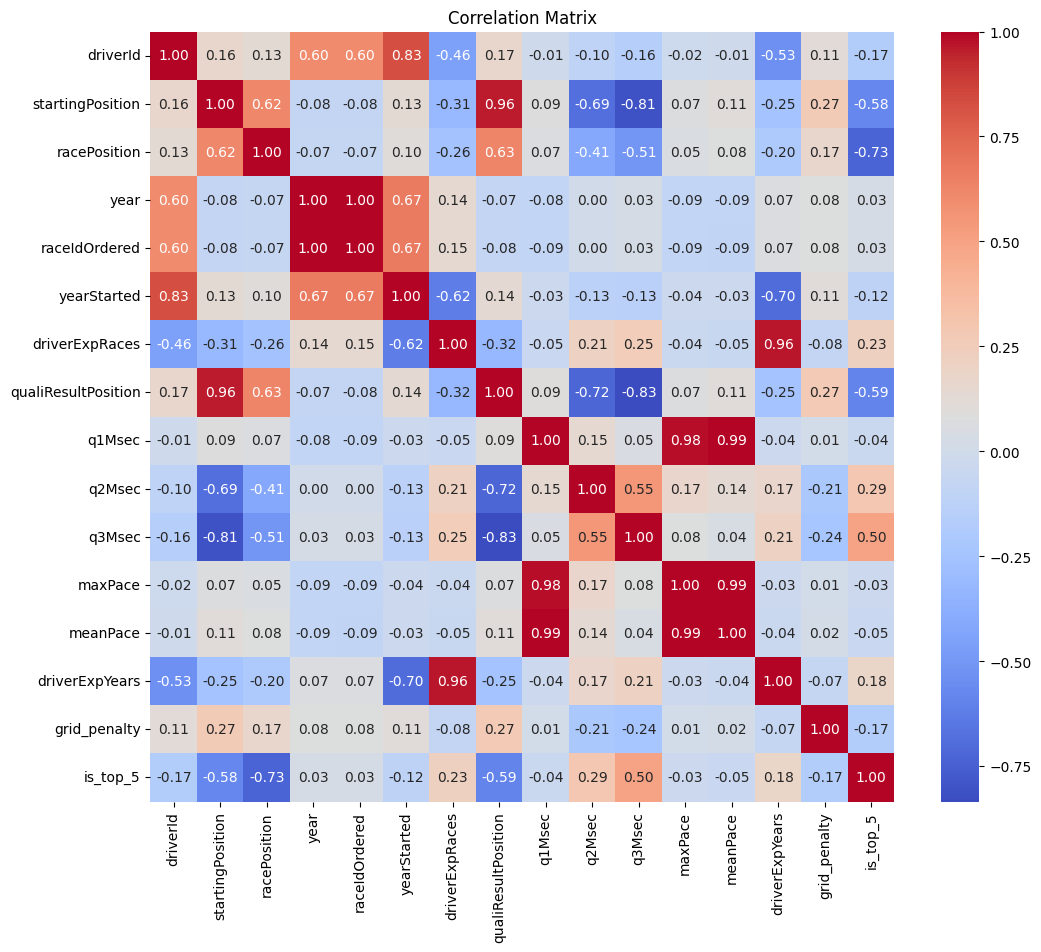

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
#correlation matrix between numerical variables
df1 = df.drop(columns=['nationality', 'raceId'])
# Calculate the correlation matrix on numerical data only
correlation_matrix = df1.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Despite our assumptions, startingPosition is not correlated to maxPace and meanPace. The reason for this might be that startingPosition is based on pace but only relatively to the other drivers.

### Machine Learning Models

We would apply 3 models to our data: 
1. Random forest
2. Decision Tree
3. Logistic Regression

In [24]:
# split the dataset 
#select driverId, qualiResultPosition, meanPace, maxPace, driverExpRaces, driveExpYears,grid_penalty as features
#select is_top_5 as target variable

X = df[['driverId', 'qualiResultPosition', 'meanPace', 'maxPace', 'driverExpYears','grid_penalty']]
y = df['is_top_5']

#see x columns
X.columns




Index(['driverId', 'qualiResultPosition', 'meanPace', 'maxPace',
       'driverExpYears', 'grid_penalty'],
      dtype='object')

In [25]:
#export df to csv
df.to_csv('df.csv', index=False)



In [ ]:
column_type = X['grid_penalty'].dtype
print(column_type)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
#import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# split the X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Seperate numerical and boolean features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
Boolean_features = X.select_dtypes(include=['bool']).columns

#numercial pipeline
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

#boolean pipeline
boolean_transformer = 'passthrough'

#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('bool', boolean_transformer, Boolean_features)
    ])

# Append classifier to preprocessing pipeline.
# Now we have the full prediction pipelines.
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])

logistic_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])




In [ ]:
rf_pipe

In [ ]:
#grid search for decision tree
param_grid = {
    'classifier__max_depth': [10, 30, 50],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

#with 3 folds 
grid_search1 = GridSearchCV(tree_pipe, param_grid, cv=5,scoring='accuracy')
grid_search1.fit(X_train, y_train)
best_tree_param = grid_search1.best_params_
print(best_tree_param)
best_tree_score = grid_search1.best_score_
print(best_tree_score)

#grid search for random forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__bootstrap': [True, False]
}

#with 3 folds
grid_search2 = GridSearchCV(rf_pipe, param_grid, cv=5,scoring='accuracy')
grid_search2.fit(X_train, y_train)
best_rf_param = grid_search2.best_params_
print(best_rf_param)
best_rf_score = grid_search2.best_score_
print(best_rf_score)

#grid search for logistic regression
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

#with 3 folds
grid_search3 = GridSearchCV(logistic_pipe, param_grid, cv=5,scoring='accuracy')
grid_search3.fit(X_train, y_train)
best_logistic_param = grid_search3.best_params_
print(best_logistic_param)
best_logistic_score = grid_search3.best_score_
print(best_logistic_score)


In [ ]:
#explore feature importance 
#fit the best model
best_model = grid_search2.best_estimator_
best_model.fit(X_train, y_train)
#feature importance
importances = best_model.named_steps['classifier'].feature_importances_
#sort feature importance
indices = np.argsort(importances)[::-1]
# Print the feature ranking with feature name and importance
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print((f + 1, X_train.columns[indices[f]], importances[indices[f]]))


Random forest shows the best accuracy. Now we finalize the pipe. 

In [ ]:
import joblib

# Update your Random Forest pipeline with the best parameters
rf_pipe.set_params(**best_rf_param)

# Retrain your pipeline on the entire training dataset
rf_pipe.fit(X_train, y_train)

# Save your finalized model to a file
joblib.dump(rf_pipe, 'finalized_random_forest_model.pkl')


Ealuate the finalized random forest model.

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Load the model
model = joblib.load('finalized_random_forest_model.pkl')

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')


## Confusion Matrix Analysis 

**Accuracy (86.20%)**:

This is quite high, indicating that overall, the model correctly predicts whether a driver will be in the top 5 about 86.20% of the time.
However, high accuracy alone isn’t always sufficient, especially if the dataset is imbalanced (i.e., if there are significantly more instances of one class than the other).


**Recall (67.41%)**:

Recall indicates the model’s ability to correctly identify actual positives.
In this case, it means that the model correctly identifies 67.41% of the drivers who actually finish in the top 5.
This is moderate performance. Depending on the context, missing out on 31.98% of the actual top 5 drivers might be a concern (for instance, if the cost of missing a top 5 driver is high).


**Precision (72.74%)**:

This metric shows that when the model predicts a driver will finish in the top 5, it is correct 72.74% of the time.
While this is a reasonably good figure, it also means that approximately 26.43% of the drivers the model predicts to be in the top 5 do not actually finish there.


**F1-Score (69.97%)**:

The F1-score is a balance between precision and recall.
An F1-score of around 69.97% is quite good, suggesting a relatively balanced performance between precision and recall.
This can be important in scenarios where both false positives and false negatives carry significant consequences.


**Confusion Matrix**:

True Positives (TP): 331 - These are cases where the model correctly predicts the top 5 finish.
True Negatives (TN): 1443 - These are cases where the model correctly identifies non-top 5 finishes.
False Positives (FP): 124 - These are cases where the model incorrectly predicts a top 5 finish.
False Negatives (FN): 160 - These are top 5 finishes that the model missed.
Considering these insights, this model shows a good balance between identifying top 5 drivers and not misclassifying too many non-top 5 drivers as top 5. 

**Future steps**: However, there is room for improvement, especially in terms of recall. Depending on the importance of either avoiding false positives or capturing more true positives (i.e., reducing false negatives), you might want to adjust the model or its threshold for classification. 

In [ ]:
import ipywidgets as widgets
from IPython.display import display


# Load your trained model
model = joblib.load('finalized_random_forest_model.pkl')

# Create widgets for each predictive factor
#['driverId', 'qualiResultPosition', q1Msec, q2Msec, q3Msec, 'driverExpYears','grid_penalty']
driverId_widget = widgets.IntText(value=1, description='Driver ID:')
qualiResultPosition_widget = widgets.FloatText(value=1, description='Quali Result Position:')
q1Msec_widget = widgets.IntText(value=0, description='Q1 Time (msec):')
q2Msec_widget = widgets.IntText(value=0, description='Q2 Time (msec):')
q3Msec_widget = widgets.IntText(value=0, description='Q3 Time (msec):')
Grid_penalty_widget = widgets.Bool(value=False, description='Is there Grid Penalty (True or False):')
driverExpYears_widget = widgets.FloatText(value=1, description='How many years of expereince does this driver have? You can look it up in our dictionary:')

# Create a button to make predictions
predict_button = widgets.Button(description='Predict')

# Define a function to be executed when the button is clicked
def on_predict_button_clicked(b):
    # Get the input values
    q_times = [q1Msec_widget.value, q2Msec_widget.value, q3Msec_widget.value]

    # Filter out zero values for meanPace calculation
    non_zero_q_times = [time for time in q_times if time != 0]

    # Calculate meanPace based on non-zero values
    if non_zero_q_times:
        meanPace = sum(non_zero_q_times) / len(non_zero_q_times)
    else:
        meanPace = 0  # You might want to handle this case separately

    # Calculate maxPace
    maxPace = max(non_zero_q_times) if non_zero_q_times else 0  # Assuming 0 as default if all are zeros
    
    # Create an array with the input values
    input_values = [
        driverId_widget.value,
        qualiResultPosition_widget.value,
        meanPace,
        maxPace,
        driverExpYears_widget.value,
        Grid_penalty_widget.value
    ] 
        
    # Reshape and predict
    prediction = model.predict([input_values])[0]
    if prediction == 1:
        print("Yes this driver will finish in top 5!")
    else:
        print("No this driver will not finish in top 5.")

# Link the button and the function
predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(driverId_widget, qualiResultPosition_widget, q1Msec_widget, q2Msec_widget, q3Msec_widget, Grid_penalty_widget, driverExpYears_widget,predict_button)
